Consolidated Metrics:
General MSE: 0.21339237417943066
SSE: 3.2008856126914593
General R²: 0.6944875760570378
--- GDP growth Metrics ---
MSE: 0.14063814361890584
R²: 0.8789429417639971
SSE: 0.7031907180945292
--- Inflation Metrics ---
MSE: 0.36289416117815965
R²: 0.3792766667070714
SSE: 1.8144708058907983
--- Gini index Metrics ---
MSE: 0.13664481774122644
R²: 0.8252431197000447
SSE: 0.6832240887061322


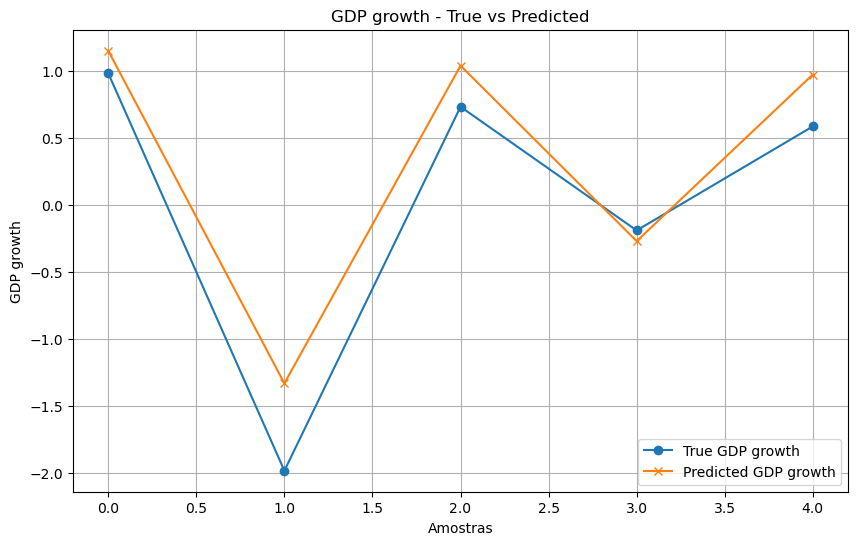

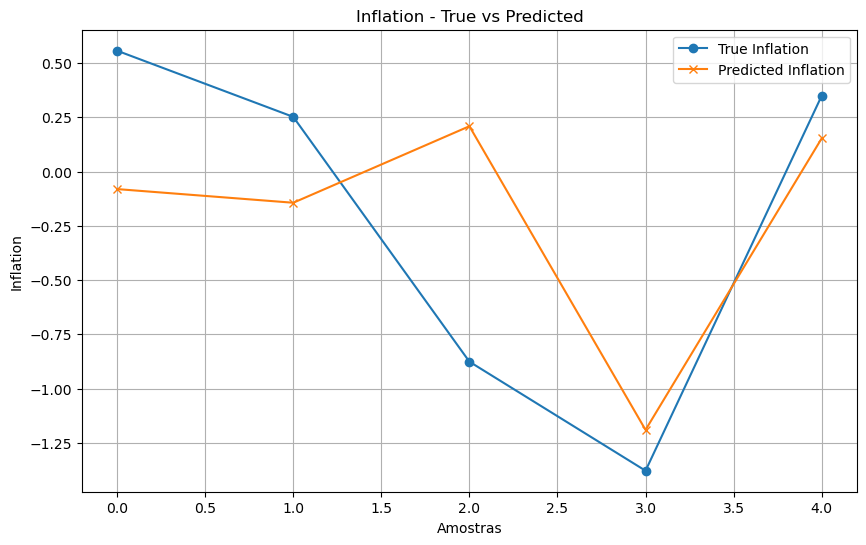

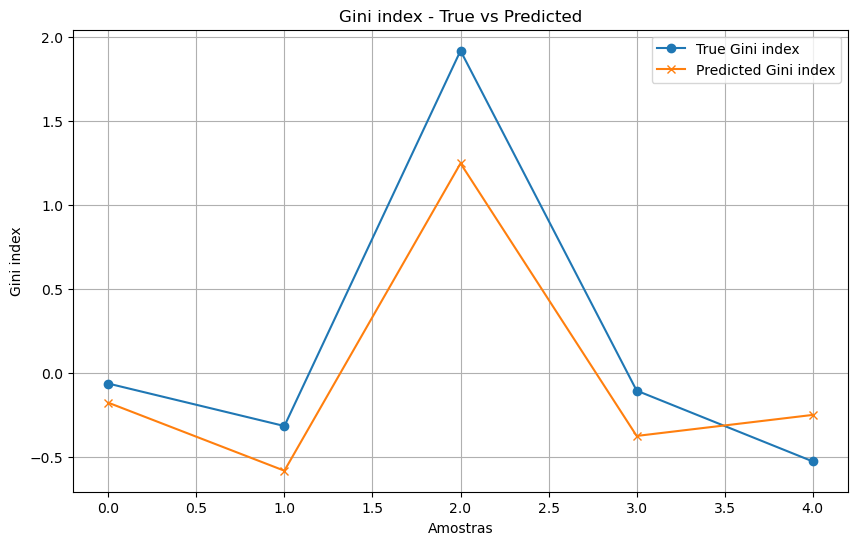

Comparison Table:
   GDP growth  Inflation  Gini index  Predicted GDP growth  \
0    0.979753   0.556737   -0.065007              1.147699   
1   -1.985435   0.251867   -0.318009             -1.333802   
2    0.729559  -0.876257    1.916837              1.036514   
3   -0.193032  -1.378780   -0.107174             -0.272692   
4    0.583063   0.348976   -0.528843              0.970094   

   Predicted Inflation  Predicted Gini index  
0            -0.080911             -0.179035  
1            -0.143848             -0.584165  
2             0.208809              1.246168  
3            -1.190562             -0.377054  
4             0.152780             -0.251803  
--- GDP growth Feature Importances by F Score ---
                     Feature  F Score
0                Legislative   3035.0
2             Administration   1519.0
7         Citizenship Rights    980.0
11                    Energy    980.0
5                     Health    636.0
8                   Urbanism    601.0
10  Environ

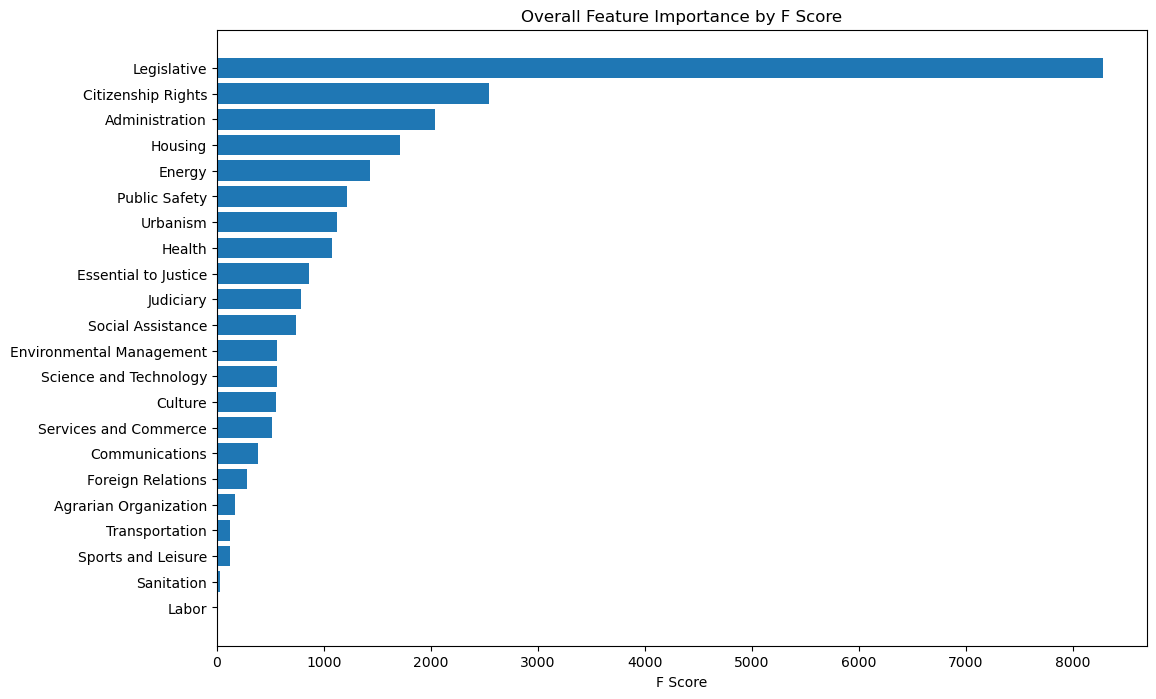

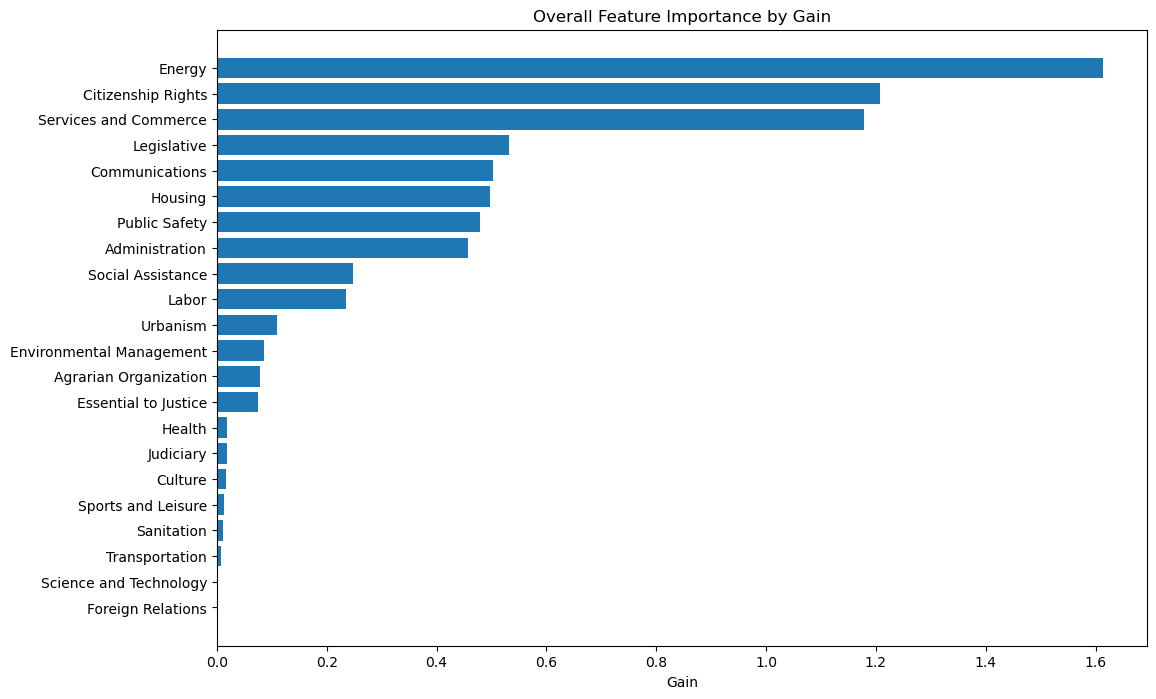

                     Feature   Coverage
19                    Energy  18.344515
8                      Labor  17.000000
17     Services and Commerce  13.000000
16     Agrarian Organization  12.000000
4              Public Safety  11.703369
10        Citizenship Rights  11.672556
6          Social Assistance  11.441296
18            Communications  11.425197
21        Sports and Leisure  11.000000
12                   Housing   9.822534
13                Sanitation   9.500000
20            Transportation   7.484127
15    Science and Technology   7.035524
3             Administration   6.400687
14  Environmental Management   6.257549
0                Legislative   5.682010
2       Essential to Justice   4.945602
11                  Urbanism   4.628114
1                  Judiciary   4.263959
7                     Health   3.746753
9                    Culture   3.591727
5          Foreign Relations   3.312057


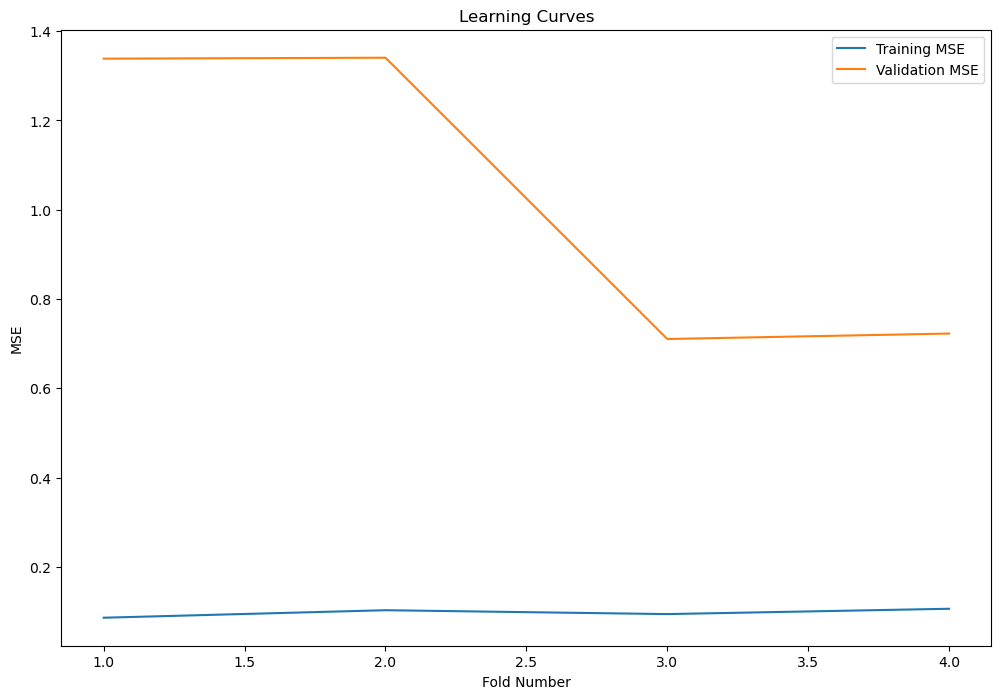

Modelo salvo com sucesso em: saved_model3.pkl


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import joblib

# Carregar os dados
df = pd.read_csv('dados_normalizados.csv')

# Separar as variáveis de entrada e saída
X = df.iloc[:, 1:-3]  # Todas as despesas orçamentárias
y = df.iloc[:, -3:]   # GDP growth, Inflation, Gini index

# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Configuração do modelo XGBoost para regressão multi-output
model = XGBRegressor(objective='reg:squarederror', n_estimators=980, learning_rate=0.002, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Avaliação final no conjunto de teste
y_pred = model.predict(X_test)
general_mse = mean_squared_error(y_test, y_pred)
general_r2 = r2_score(y_test, y_pred)
general_sse = np.sum((y_test.values - y_pred) ** 2)

# Métricas detalhadas para cada variável
detailed_metrics = {}
for i, column in enumerate(y_test.columns):
    mse = mean_squared_error(y_test[column], y_pred[:, i])
    r2 = r2_score(y_test[column], y_pred[:, i])
    sse = np.sum((y_test[column].values - y_pred[:, i]) ** 2)
    detailed_metrics[column] = {'MSE': mse, 'R²': r2, 'SSE': sse}

# Mostrar métricas consolidadas
print("Consolidated Metrics:")
print(f"General MSE: {general_mse}")
print(f'SSE: {general_sse}')
print(f"General R²: {general_r2}")

# Mostrar métricas detalhadas
for variable, metrics in detailed_metrics.items():
    print(f"--- {variable} Metrics ---")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")

# Comparação visual entre valores reais e preditos
def plot_comparison(y_true, y_pred, labels):
    for i, label in enumerate(labels):
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(y_true)), y_true[:, i], label=f'True {label}', marker='o')
        plt.plot(range(len(y_true)), y_pred[:, i], label=f'Predicted {label}', marker='x')
        plt.legend()
        plt.title(f'{label} - True vs Predicted')
        plt.xlabel('Amostras')
        plt.ylabel(label)
        plt.grid(True)
        plt.show()

labels = ['GDP growth', 'Inflation', 'Gini index']
plot_comparison(y_test.values, y_pred, labels)

# Comparação tabular entre valores reais e preditos
comparison_df = pd.DataFrame(y_test.values, columns=labels)
comparison_df['Predicted GDP growth'] = y_pred[:, 0]
comparison_df['Predicted Inflation'] = y_pred[:, 1]
comparison_df['Predicted Gini index'] = y_pred[:, 2]

print("Comparison Table:")
print(comparison_df.head())

# Salvar a tabela de comparação em CSV
comparison_df.to_csv('comparison_table.csv', index=False)

# Cálculo e visualização da importância das características para cada saída e geral
outputs = y.columns.tolist() + ['overall']
features_dict_f = {}
features_dict_gain = {}

for output in outputs:
    if output == 'overall':
        booster = model.get_booster()
    else:
        temp_model = XGBRegressor(objective='reg:squarederror', n_estimators=980, learning_rate=0.002, random_state=42, n_jobs=-1)
        temp_model.fit(X_train, y_train[output])
        booster = temp_model.get_booster()

    feature_importances = booster.get_score(importance_type='weight')
    feature_importances_gain = booster.get_score(importance_type='gain')

    features_f = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'F Score']).sort_values(by='F Score', ascending=False)
    features_gain = pd.DataFrame(list(feature_importances_gain.items()), columns=['Feature', 'Gain']).sort_values(by='Gain', ascending=False)

    features_dict_f[output] = features_f
    features_dict_gain[output] = features_gain

    print(f"--- {output} Feature Importances by F Score ---")
    print(features_f)
    print(f"--- {output} Feature Importances by Gain ---")
    print(features_gain)

# Gráficos de Importância das Características (Consolidados)
plt.figure(figsize=(12, 8))
plt.barh(features_f['Feature'], features_f['F Score'])
plt.xlabel('F Score')
plt.title('Overall Feature Importance by F Score')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(12, 8))
plt.barh(features_gain['Feature'], features_gain['Gain'])
plt.xlabel('Gain')
plt.title('Overall Feature Importance by Gain')
plt.gca().invert_yaxis()
plt.show()

# Para Cobertura
feature_importances_cover = model.get_booster().get_score(importance_type='cover')
features_cover = pd.DataFrame(list(feature_importances_cover.items()), columns=['Feature', 'Coverage']).sort_values(by='Coverage', ascending=False)
print(features_cover)

# Curvas de aprendizado
kf = KFold(n_splits=4, shuffle=True, random_state=42)
train_scores, val_scores = [], []
for train_index, val_index in kf.split(X_train):
    X_train_k, X_val_k = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_k, y_val_k = y_train.iloc[train_index], y_train.iloc[val_index]
    model.fit(X_train_k, y_train_k)
    train_scores.append(mean_squared_error(y_train_k, model.predict(X_train_k)))
    val_scores.append(mean_squared_error(y_val_k, model.predict(X_val_k)))

plt.figure(figsize=(12, 8))
plt.plot(range(1, 5), train_scores, label='Training MSE')
plt.plot(range(1, 5), val_scores, label='Validation MSE')
plt.title('Learning Curves')
plt.xlabel('Fold Number')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Salvar o modelo treinado na área de arquivos do Jupyter Notebook
# Defina o caminho do arquivo onde o modelo será salvo
model_path = 'saved_model3.pkl'

# Salvar o modelo treinado
joblib.dump(model, model_path)

# Confirme que o modelo foi salvo corretamente
print("Modelo salvo com sucesso em:", model_path)


Métricas Consolidadas:
General MSE: 0.21339237417943066
General SSE: 3.2008856126914593
General R²: 0.6944875760570378
--- GDP growth Metrics ---
MSE: 0.14063814361890584
R²: 0.8789429417639971
SSE: 0.7031907180945292
--- Inflation Metrics ---
MSE: 0.36289416117815965
R²: 0.3792766667070714
SSE: 1.8144708058907983
--- Gini index Metrics ---
MSE: 0.13664481774122644
R²: 0.8252431197000447
SSE: 0.6832240887061322


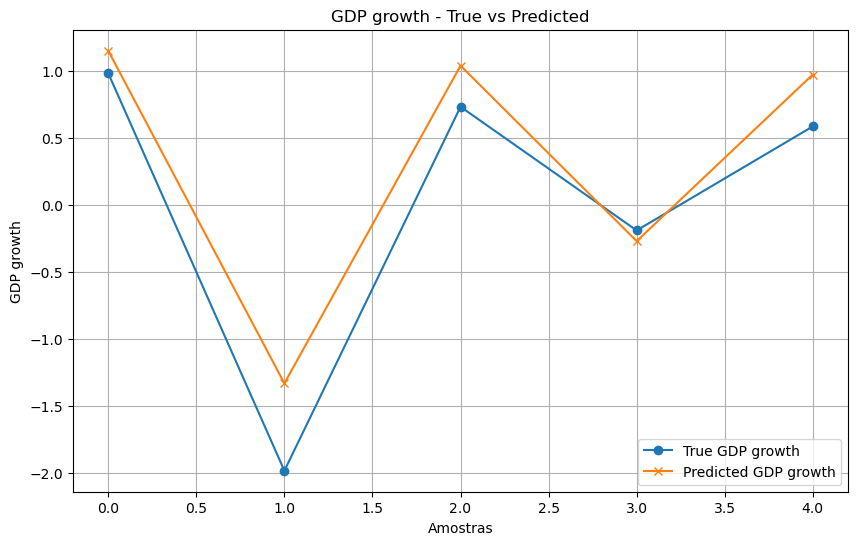

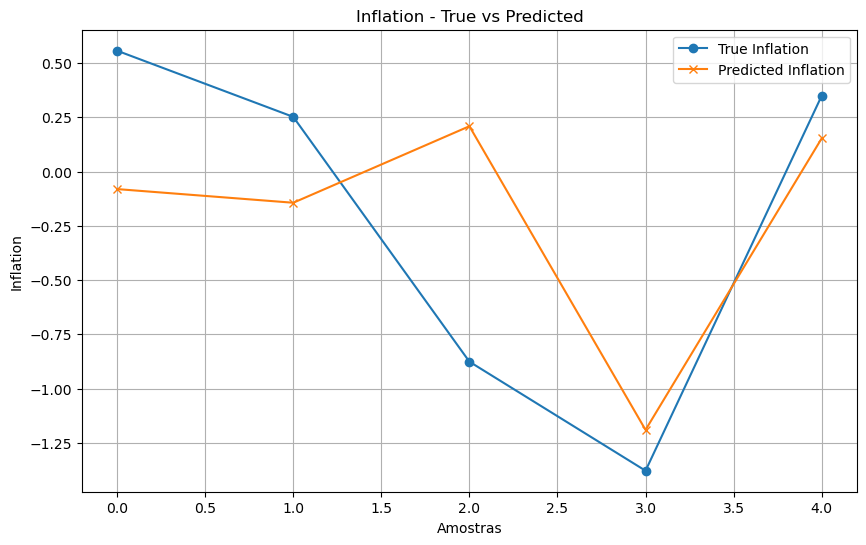

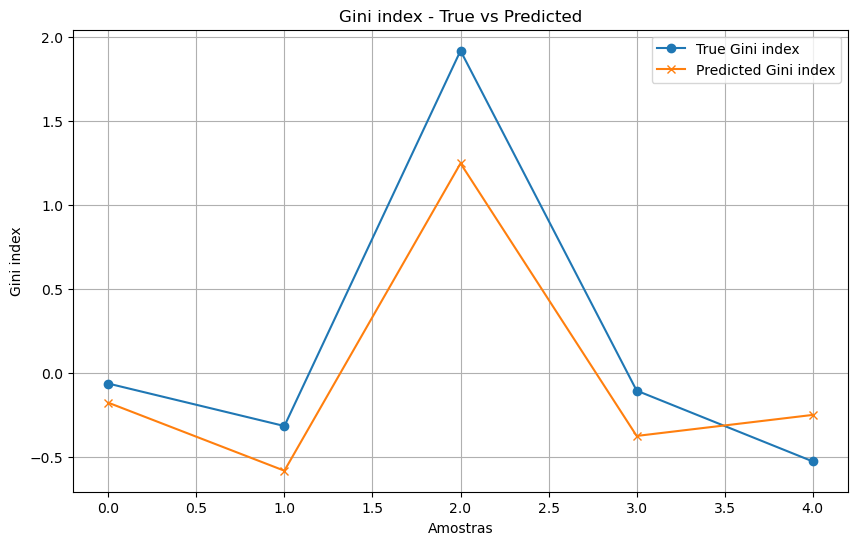

Tabela de Comparação:
   GDP growth  Inflation  Gini index  Predicted GDP growth  \
0    0.979753   0.556737   -0.065007              1.147699   
1   -1.985435   0.251867   -0.318009             -1.333802   
2    0.729559  -0.876257    1.916837              1.036514   
3   -0.193032  -1.378780   -0.107174             -0.272692   
4    0.583063   0.348976   -0.528843              0.970094   

   Predicted Inflation  Predicted Gini index  
0            -0.080911             -0.179035  
1            -0.143848             -0.584165  
2             0.208809              1.246168  
3            -1.190562             -0.377054  
4             0.152780             -0.251803  
--- GDP growth Feature Importances by Weight ---
                     Feature  Weight
0                Legislative  3035.0
2             Administration  1519.0
7         Citizenship Rights   980.0
11                    Energy   980.0
5                     Health   636.0
8                   Urbanism   601.0
10  Environment

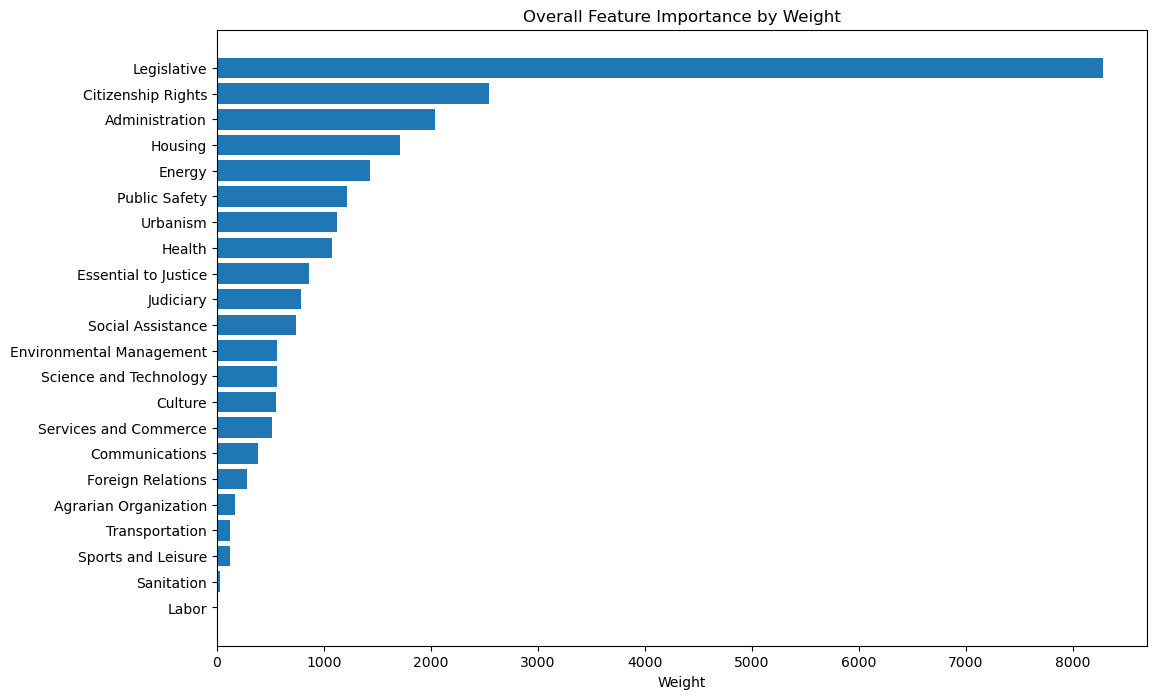

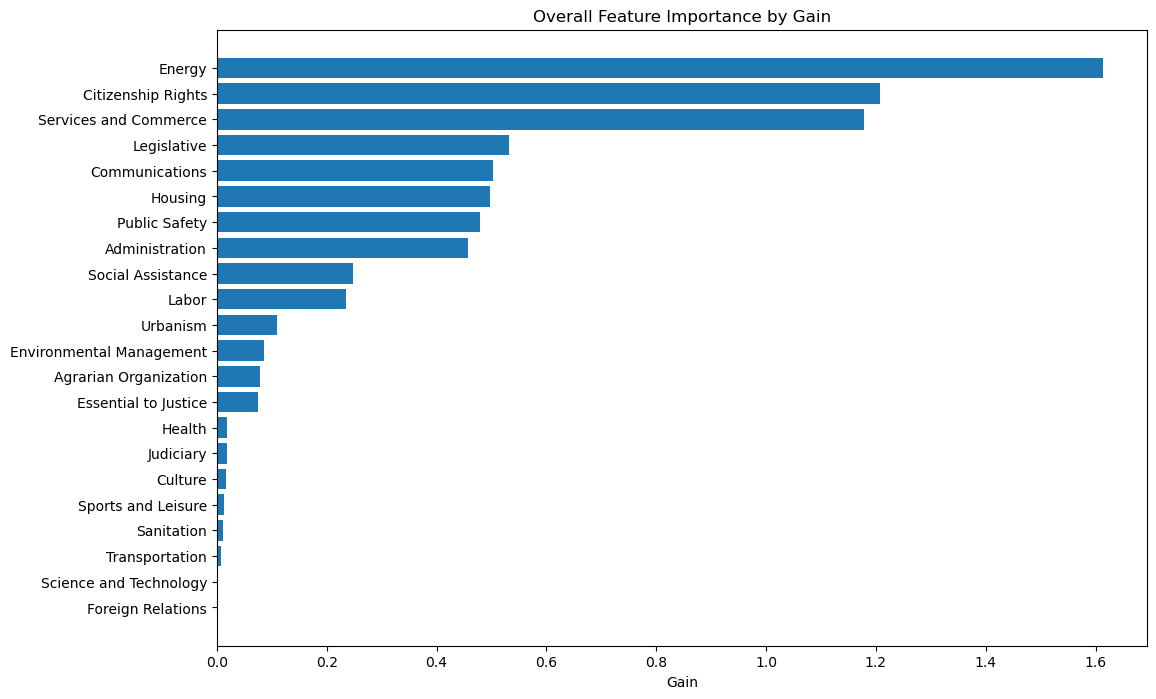

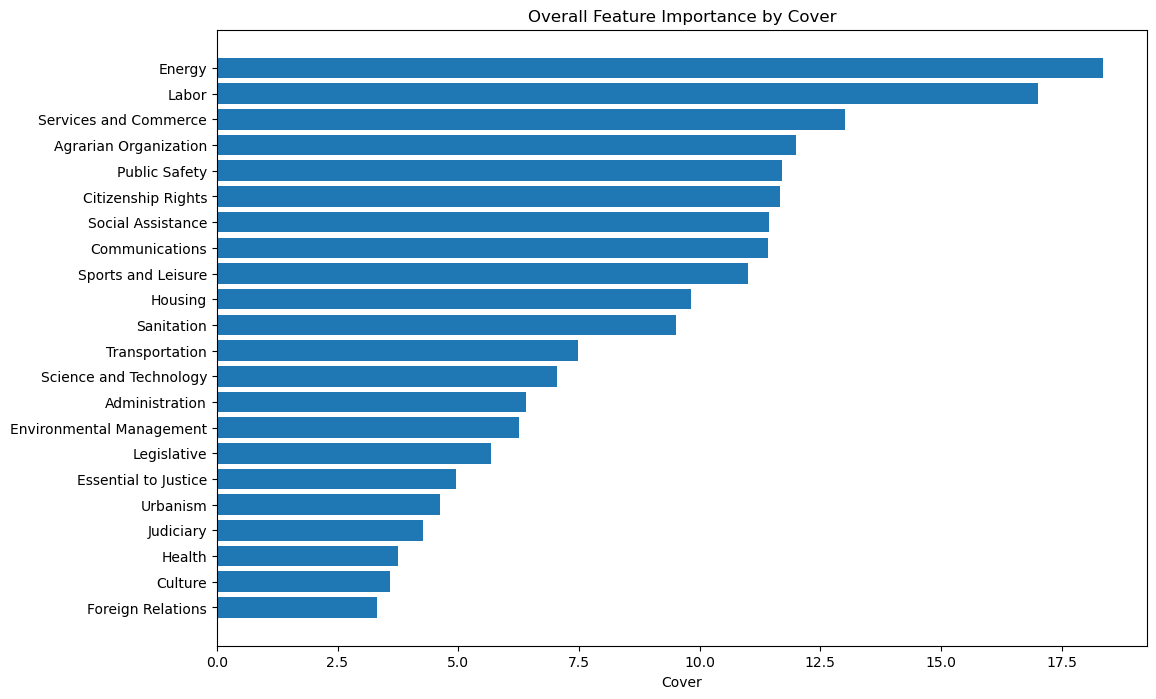

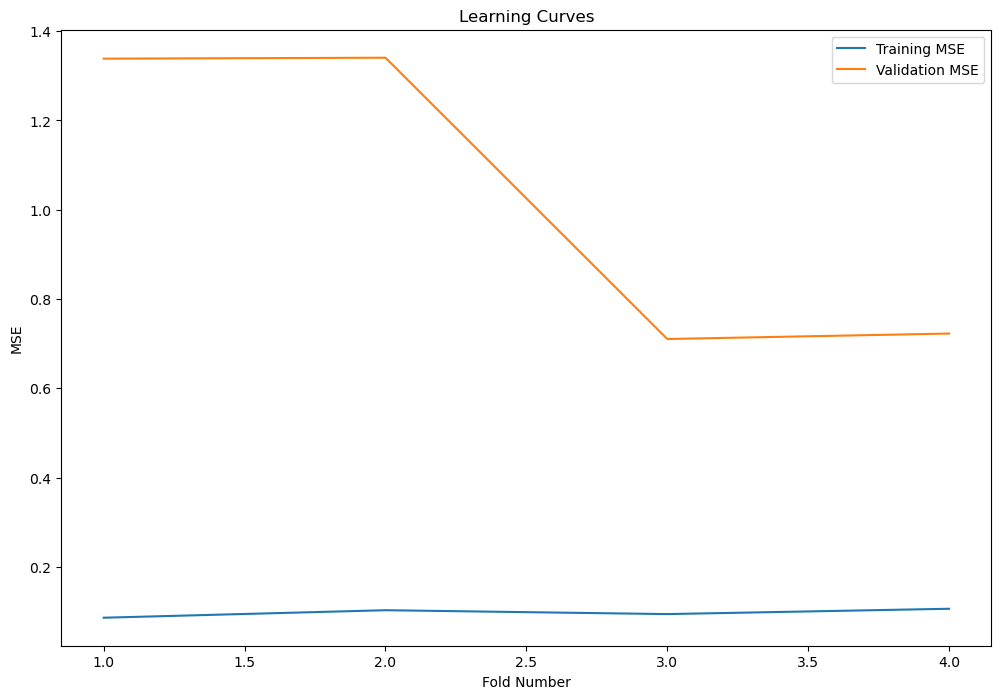

Modelo salvo com sucesso em: saved_model3.pkl
Tempo total de execução: 00:00:15


In [1]:
# Instalar bibliotecas necessárias
!pip install shap

# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import time
import os

def load_data(filepath):
    """Carrega os dados de um arquivo CSV."""
    return pd.read_csv(filepath)

def prepare_data(df):
    """Separa as variáveis de entrada (X) e saída (y)."""
    X = df.iloc[:, 1:-3]
    y = df.iloc[:, -3:]
    return train_test_split(X, y, test_size=0.2, random_state=42)

def train_model(X_train, y_train):
    """Configura e treina o modelo XGBoost."""
    model = XGBRegressor(objective='reg:squarederror', n_estimators=980, learning_rate=0.002, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    """Avalia o modelo no conjunto de teste."""
    y_pred = model.predict(X_test)
    general_mse = mean_squared_error(y_test, y_pred)
    general_r2 = r2_score(y_test, y_pred)
    general_sse = np.sum((y_test.values - y_pred) ** 2)
    return y_pred, general_mse, general_r2, general_sse

def calculate_detailed_metrics(y_test, y_pred):
    """Calcula métricas detalhadas para cada variável de saída."""
    detailed_metrics = {}
    for i, column in enumerate(y_test.columns):
        mse = mean_squared_error(y_test[column], y_pred[:, i])
        r2 = r2_score(y_test[column], y_pred[:, i])
        sse = np.sum((y_test[column].values - y_pred[:, i]) ** 2)
        detailed_metrics[column] = {'MSE': mse, 'R²': r2, 'SSE': sse}
    return detailed_metrics

def plot_comparison(y_true, y_pred, labels):
    """Plota a comparação visual entre valores reais e preditos."""
    for i, label in enumerate(labels):
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(y_true)), y_true[:, i], label=f'True {label}', marker='o')
        plt.plot(range(len(y_true)), y_pred[:, i], label=f'Predicted {label}', marker='x')
        plt.legend()
        plt.title(f'{label} - True vs Predicted')
        plt.xlabel('Amostras')
        plt.ylabel(label)
        plt.grid(True)
        plt.show()

def save_comparison_table(y_test, y_pred, labels, filename):
    """Salva a tabela de comparação entre valores reais e preditos em CSV."""
    comparison_df = pd.DataFrame(y_test.values, columns=labels)
    comparison_df['Predicted GDP growth'] = y_pred[:, 0]
    comparison_df['Predicted Inflation'] = y_pred[:, 1]
    comparison_df['Predicted Gini index'] = y_pred[:, 2]
    comparison_df.to_csv(filename, index=False)
    return comparison_df

def calculate_feature_importances(model, X_train, y_train, outputs):
    """Calcula e salva a importância das características."""
    features_dict_weight = {}
    features_dict_gain = {}
    features_dict_cover = {}

    for output in outputs:
        if output == 'overall':
            booster = model.get_booster()
        else:
            temp_model = XGBRegressor(objective='reg:squarederror', n_estimators=980, learning_rate=0.002, random_state=42, n_jobs=-1)
            temp_model.fit(X_train, y_train[output])
            booster = temp_model.get_booster()

        feature_importances_weight = booster.get_score(importance_type='weight')
        feature_importances_gain = booster.get_score(importance_type='gain')
        feature_importances_cover = booster.get_score(importance_type='cover')

        features_weight = pd.DataFrame(list(feature_importances_weight.items()), columns=['Feature', 'Weight']).sort_values(by='Weight', ascending=False)
        features_gain = pd.DataFrame(list(feature_importances_gain.items()), columns=['Feature', 'Gain']).sort_values(by='Gain', ascending=False)
        features_cover = pd.DataFrame(list(feature_importances_cover.items()), columns=['Feature', 'Cover']).sort_values(by='Cover', ascending=False)

        features_dict_weight[output] = features_weight
        features_dict_gain[output] = features_gain
        features_dict_cover[output] = features_cover

        print(f"--- {output} Feature Importances by Weight ---")
        print(features_weight)
        print(f"--- {output} Feature Importances by Gain ---")
        print(features_gain)
        print(f"--- {output} Feature Importances by Cover ---")
        print(features_cover)
        
        features_weight.to_csv(f'feature_importances_weight_{output}.csv', index=False)
        features_gain.to_csv(f'feature_importances_gain_{output}.csv', index=False)
        features_cover.to_csv(f'feature_importances_cover_{output}.csv', index=False)

    return features_dict_weight, features_dict_gain, features_dict_cover

def plot_feature_importance(features, importance_type):
    """Plota a importância das características."""
    plt.figure(figsize=(12, 8))
    plt.barh(features['Feature'], features[importance_type])
    plt.xlabel(importance_type)
    plt.title(f'Overall Feature Importance by {importance_type}')
    plt.gca().invert_yaxis()
    plt.show()

def plot_learning_curves(X_train, y_train, model):
    """Plota as curvas de aprendizado."""
    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    train_scores, val_scores = [], []
    for train_index, val_index in kf.split(X_train):
        X_train_k, X_val_k = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_k, y_val_k = y_train.iloc[train_index], y_train.iloc[val_index]
        model.fit(X_train_k, y_train_k)
        train_scores.append(mean_squared_error(y_train_k, model.predict(X_train_k)))
        val_scores.append(mean_squared_error(y_val_k, model.predict(X_val_k)))

    plt.figure(figsize=(12, 8))
    plt.plot(range(1, 5), train_scores, label='Training MSE')
    plt.plot(range(1, 5), val_scores, label='Validation MSE')
    plt.title('Learning Curves')
    plt.xlabel('Fold Number')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

def save_model(model, filepath):
    """Salva o modelo treinado."""
    joblib.dump(model, filepath)
    print(f"Modelo salvo com sucesso em: {filepath}")

# Script principal
def main():
    # Registrar o tempo de início
    start_time = time.time()

    # Caminho para o arquivo de dados e modelo
    data_path = 'Processed_Normalized_Data.csv'
    model_path = 'saved_model3.pkl'

    # Carregar e preparar os dados
    df = load_data(data_path)
    X_train, X_test, y_train, y_test = prepare_data(df)

    # Treinar o modelo
    model = train_model(X_train, y_train)

    # Avaliar o modelo
    y_pred, general_mse, general_r2, general_sse = evaluate_model(model, X_test, y_test)

    # Calcular métricas detalhadas
    detailed_metrics = calculate_detailed_metrics(y_test, y_pred)

    # Mostrar métricas
    print("Métricas Consolidadas:")
    print(f"General MSE: {general_mse}")
    print(f"General SSE: {general_sse}")
    print(f"General R²: {general_r2}")

    for variable, metrics in detailed_metrics.items():
        print(f"--- {variable} Metrics ---")
        for metric_name, metric_value in metrics.items():
            print(f"{metric_name}: {metric_value}")

    # Comparação visual e tabular
    labels = ['GDP growth', 'Inflation', 'Gini index']
    plot_comparison(y_test.values, y_pred, labels)
    comparison_df = save_comparison_table(y_test, y_pred, labels, 'comparison_table.csv')
    print("Tabela de Comparação:")
    print(comparison_df.head())

    # Calcular e salvar importâncias das características
    outputs = y_train.columns.tolist() + ['overall']
    features_dict_weight, features_dict_gain, features_dict_cover = calculate_feature_importances(model, X_train, y_train, outputs)

    # Plotar importâncias das características
    plot_feature_importance(features_dict_weight['overall'], 'Weight')
    plot_feature_importance(features_dict_gain['overall'], 'Gain')
    plot_feature_importance(features_dict_cover['overall'], 'Cover')

    # Plotar curvas de aprendizado
    plot_learning_curves(X_train, y_train, model)

    # Salvar o modelo
    save_model(model, model_path)

    # Registrar o tempo de término
    end_time = time.time()

    # Calcular e exibir o tempo total de execução
    execution_time = end_time - start_time
    hours, rem = divmod(execution_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print(f"Tempo total de execução: {int(hours):02}:{int(minutes):02}:{int(seconds):02}")

if __name__ == "__main__":
    main()


Métricas Consolidadas:
General MSE: 0.21339237417943066
General SSE: 3.2008856126914593
General R²: 0.6944875760570378
--- GDP growth Metrics ---
MSE: 0.14063814361890584
R²: 0.8789429417639971
SSE: 0.7031907180945292
--- Inflation Metrics ---
MSE: 0.36289416117815965
R²: 0.3792766667070714
SSE: 1.8144708058907983
--- Gini index Metrics ---
MSE: 0.13664481774122644
R²: 0.8252431197000447
SSE: 0.6832240887061322


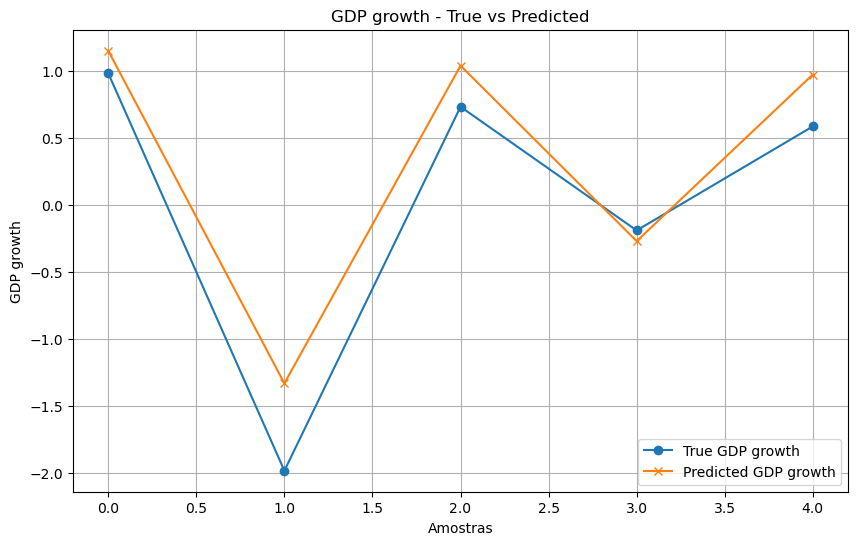

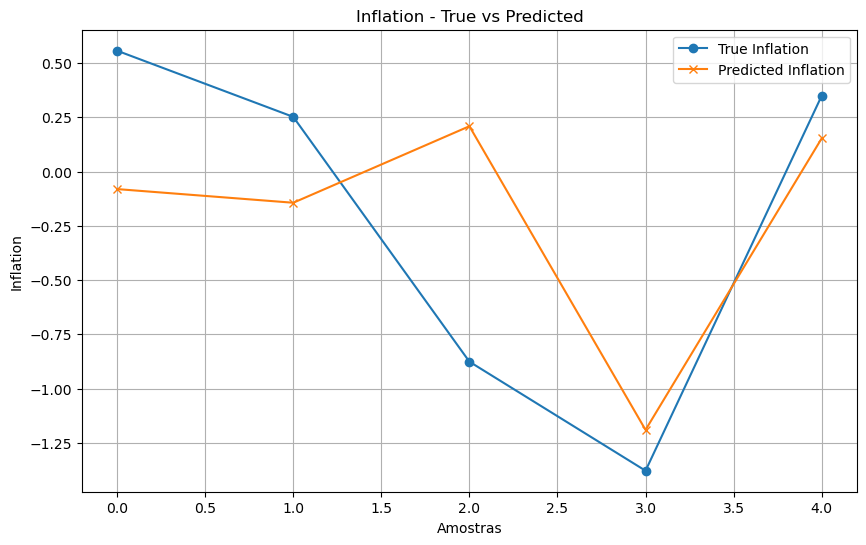

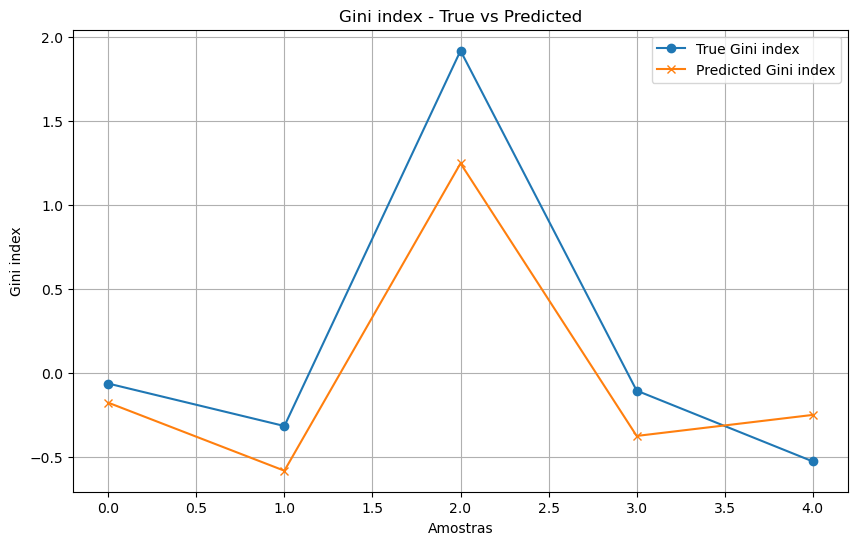

Tabela de Comparação:
   GDP growth  Inflation  Gini index  Predicted GDP growth  \
0    0.979753   0.556737   -0.065007              1.147699   
1   -1.985435   0.251867   -0.318009             -1.333802   
2    0.729559  -0.876257    1.916837              1.036514   
3   -0.193032  -1.378780   -0.107174             -0.272692   
4    0.583063   0.348976   -0.528843              0.970094   

   Predicted Inflation  Predicted Gini index  
0            -0.080911             -0.179035  
1            -0.143848             -0.584165  
2             0.208809              1.246168  
3            -1.190562             -0.377054  
4             0.152780             -0.251803  
--- GDP growth Feature Importances by Weight ---
                     Feature  Weight
0                Legislative  3035.0
2             Administration  1519.0
7         Citizenship Rights   980.0
11                    Energy   980.0
5                     Health   636.0
8                   Urbanism   601.0
10  Environment

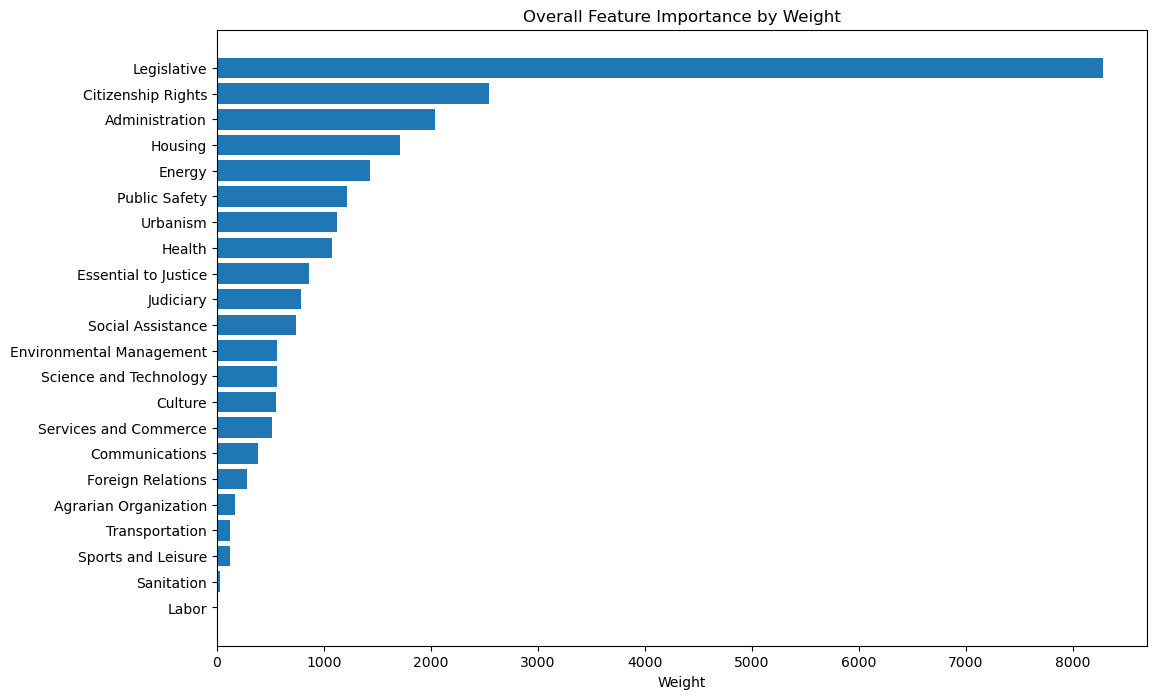

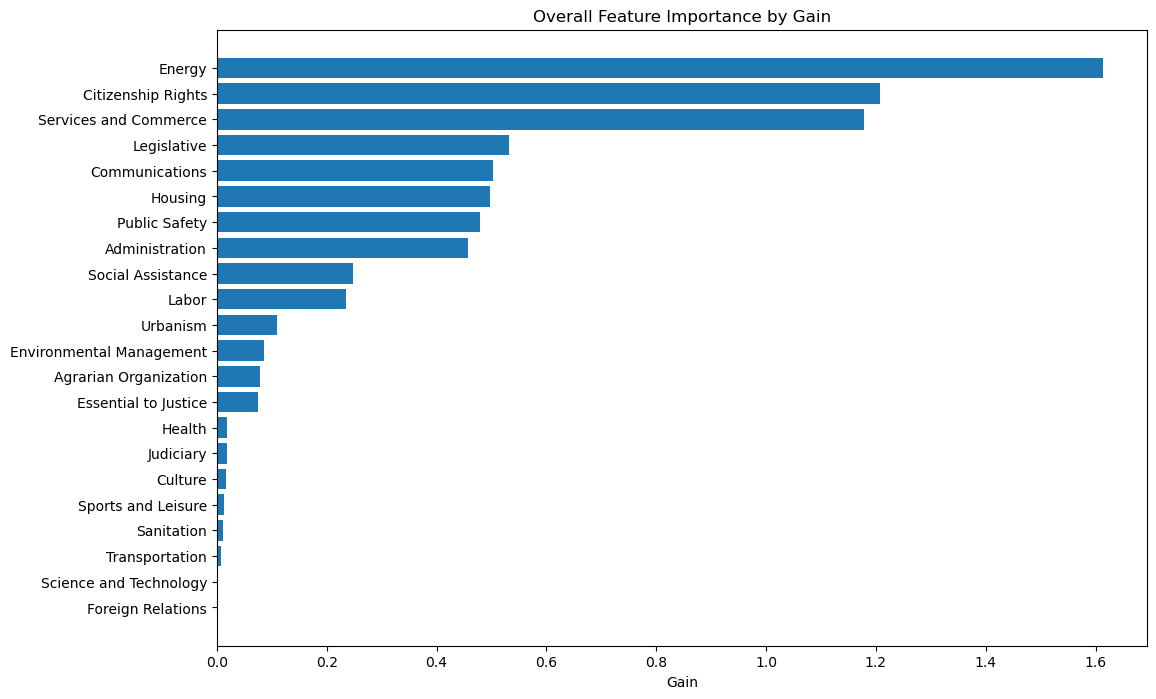

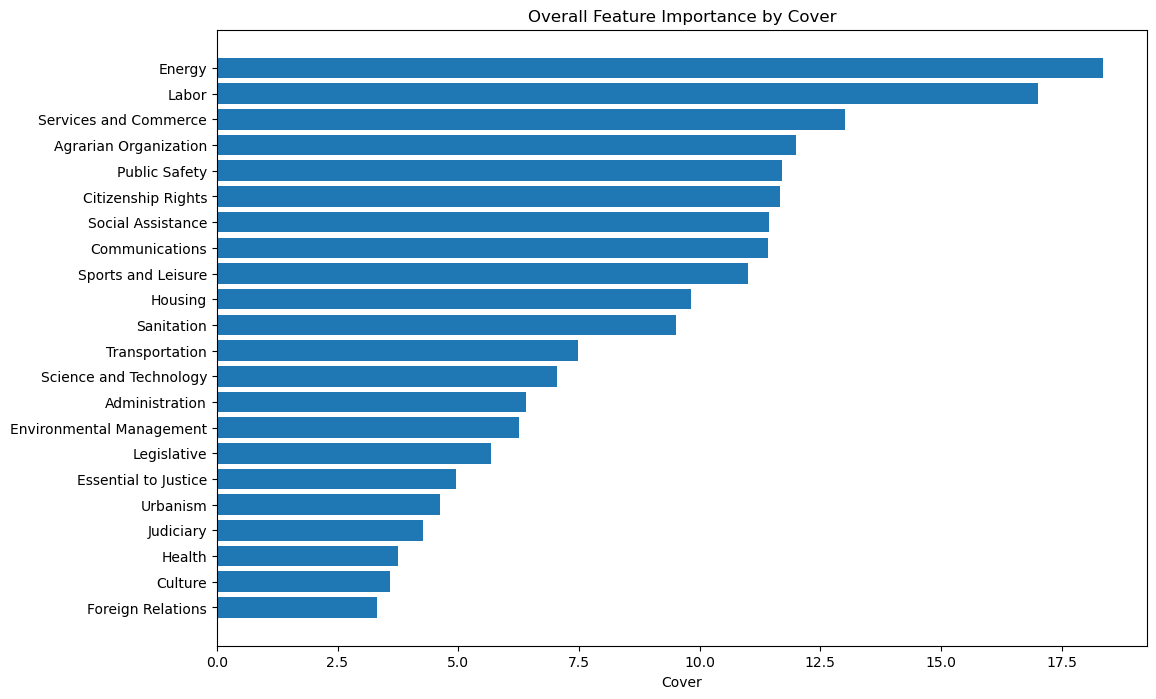

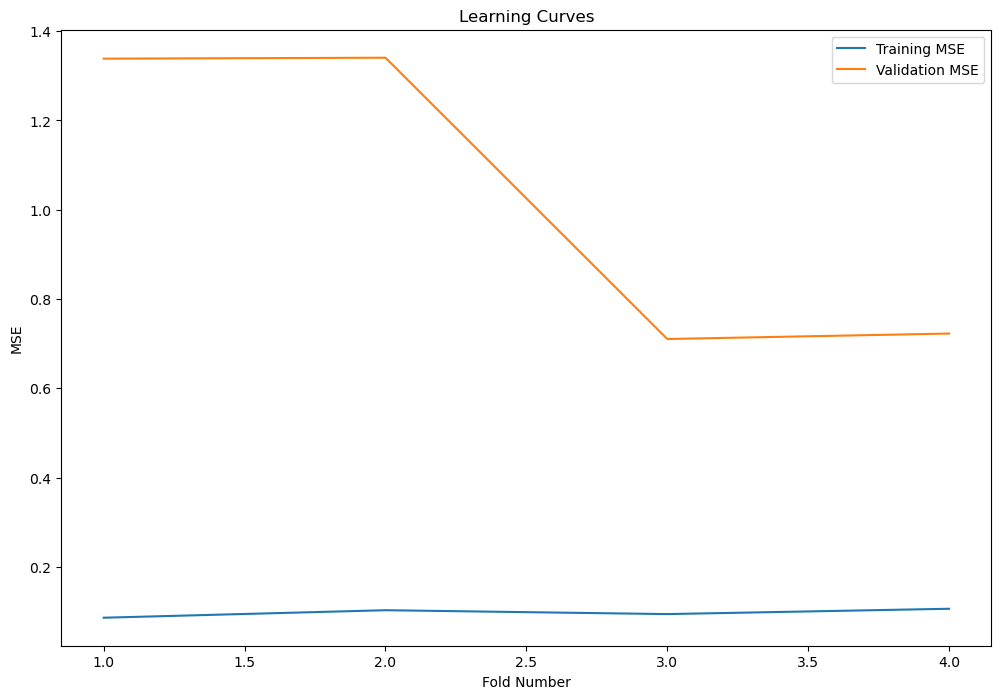

Modelo salvo com sucesso em: saved_model3.json
Tempo total de execução: 00:00:07


NameError: name 'xgboost' is not defined

In [3]:
# Instalar bibliotecas necessárias
!pip install shap xgboost scikit-learn joblib matplotlib pandas

# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, Booster
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import time

# Função para carregar os dados
def load_data(filepath):
    """Carrega os dados de um arquivo CSV."""
    return pd.read_csv(filepath)

# Função para preparar os dados
def prepare_data(df):
    """Separa as variáveis de entrada (X) e saída (y)."""
    X = df.iloc[:, 1:-3]
    y = df.iloc[:, -3:]
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Função para treinar o modelo
def train_model(X_train, y_train):
    """Configura e treina o modelo XGBoost."""
    model = XGBRegressor(objective='reg:squarederror', n_estimators=980, learning_rate=0.002, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    return model

# Função para avaliar o modelo
def evaluate_model(model, X_test, y_test):
    """Avalia o modelo no conjunto de teste."""
    y_pred = model.predict(X_test)
    general_mse = mean_squared_error(y_test, y_pred)
    general_r2 = r2_score(y_test, y_pred)
    general_sse = np.sum((y_test.values - y_pred) ** 2)
    return y_pred, general_mse, general_r2, general_sse

# Função para calcular métricas detalhadas
def calculate_detailed_metrics(y_test, y_pred):
    """Calcula métricas detalhadas para cada variável de saída."""
    detailed_metrics = {}
    for i, column in enumerate(y_test.columns):
        mse = mean_squared_error(y_test[column], y_pred[:, i])
        r2 = r2_score(y_test[column], y_pred[:, i])
        sse = np.sum((y_test[column].values - y_pred[:, i]) ** 2)
        detailed_metrics[column] = {'MSE': mse, 'R²': r2, 'SSE': sse}
    return detailed_metrics

# Função para plotar comparação entre valores reais e preditos
def plot_comparison(y_true, y_pred, labels):
    """Plota a comparação visual entre valores reais e preditos."""
    for i, label in enumerate(labels):
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(y_true)), y_true[:, i], label=f'True {label}', marker='o')
        plt.plot(range(len(y_true)), y_pred[:, i], label=f'Predicted {label}', marker='x')
        plt.legend()
        plt.title(f'{label} - True vs Predicted')
        plt.xlabel('Amostras')
        plt.ylabel(label)
        plt.grid(True)
        plt.show()

# Função para salvar a tabela de comparação em CSV
def save_comparison_table(y_test, y_pred, labels, filename):
    """Salva a tabela de comparação entre valores reais e preditos em CSV."""
    comparison_df = pd.DataFrame(y_test.values, columns=labels)
    comparison_df['Predicted GDP growth'] = y_pred[:, 0]
    comparison_df['Predicted Inflation'] = y_pred[:, 1]
    comparison_df['Predicted Gini index'] = y_pred[:, 2]
    comparison_df.to_csv(filename, index=False)
    return comparison_df

# Função para calcular e salvar importâncias das características
def calculate_feature_importances(model, X_train, y_train, outputs):
    """Calcula e salva a importância das características."""
    features_dict_weight = {}
    features_dict_gain = {}
    features_dict_cover = {}

    for output in outputs:
        if output == 'overall':
            booster = model.get_booster()
        else:
            temp_model = XGBRegressor(objective='reg:squarederror', n_estimators=980, learning_rate=0.002, random_state=42, n_jobs=-1)
            temp_model.fit(X_train, y_train[output])
            booster = temp_model.get_booster()

        feature_importances_weight = booster.get_score(importance_type='weight')
        feature_importances_gain = booster.get_score(importance_type='gain')
        feature_importances_cover = booster.get_score(importance_type='cover')

        features_weight = pd.DataFrame(list(feature_importances_weight.items()), columns=['Feature', 'Weight']).sort_values(by='Weight', ascending=False)
        features_gain = pd.DataFrame(list(feature_importances_gain.items()), columns=['Feature', 'Gain']).sort_values(by='Gain', ascending=False)
        features_cover = pd.DataFrame(list(feature_importances_cover.items()), columns=['Feature', 'Cover']).sort_values(by='Cover', ascending=False)

        features_dict_weight[output] = features_weight
        features_dict_gain[output] = features_gain
        features_dict_cover[output] = features_cover

        print(f"--- {output} Feature Importances by Weight ---")
        print(features_weight)
        print(f"--- {output} Feature Importances by Gain ---")
        print(features_gain)
        print(f"--- {output} Feature Importances by Cover ---")
        print(features_cover)
        
        features_weight.to_csv(f'feature_importances_weight_{output}.csv', index=False)
        features_gain.to_csv(f'feature_importances_gain_{output}.csv', index=False)
        features_cover.to_csv(f'feature_importances_cover_{output}.csv', index=False)

    return features_dict_weight, features_dict_gain, features_dict_cover

# Função para plotar importância das características
def plot_feature_importance(features, importance_type):
    """Plota a importância das características."""
    plt.figure(figsize=(12, 8))
    plt.barh(features['Feature'], features[importance_type])
    plt.xlabel(importance_type)
    plt.title(f'Overall Feature Importance by {importance_type}')
    plt.gca().invert_yaxis()
    plt.show()

# Função para plotar curvas de aprendizado
def plot_learning_curves(X_train, y_train, model):
    """Plota as curvas de aprendizado."""
    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    train_scores, val_scores = [], []
    for train_index, val_index in kf.split(X_train):
        X_train_k, X_val_k = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_k, y_val_k = y_train.iloc[train_index], y_train.iloc[val_index]
        model.fit(X_train_k, y_train_k)
        train_scores.append(mean_squared_error(y_train_k, model.predict(X_train_k)))
        val_scores.append(mean_squared_error(y_val_k, model.predict(X_val_k)))

    plt.figure(figsize=(12, 8))
    plt.plot(range(1, 5), train_scores, label='Training MSE')
    plt.plot(range(1, 5), val_scores, label='Validation MSE')
    plt.title('Learning Curves')
    plt.xlabel('Fold Number')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

# Função para salvar o modelo
def save_model(model, filepath):
    """Salva o modelo treinado."""
    # Salvar o modelo no formato JSON, que é mais seguro para versões futuras
    model.get_booster().save_model(filepath.replace('.pkl', '.json'))
    print(f"Modelo salvo com sucesso em: {filepath.replace('.pkl', '.json')}")

# Script principal
def main():
    # Registrar o tempo de início
    start_time = time.time()

    # Caminho para o arquivo de dados e modelo
    data_path = 'Processed_Normalized_Data.csv'
    model_path = 'saved_model3.json'  # Usar .json ao invés de .pkl

    # Carregar e preparar os dados
    df = load_data(data_path)
    X_train, X_test, y_train, y_test = prepare_data(df)

    # Treinar o modelo
    model = train_model(X_train, y_train)

    # Avaliar o modelo
    y_pred, general_mse, general_r2, general_sse = evaluate_model(model, X_test, y_test)

    # Calcular métricas detalhadas
    detailed_metrics = calculate_detailed_metrics(y_test, y_pred)

    # Mostrar métricas
    print("Métricas Consolidadas:")
    print(f"General MSE: {general_mse}")
    print(f"General SSE: {general_sse}")
    print(f"General R²: {general_r2}")

    for variable, metrics in detailed_metrics.items():
        print(f"--- {variable} Metrics ---")
        for metric_name, metric_value in metrics.items():
            print(f"{metric_name}: {metric_value}")

    # Comparação visual e tabular
    labels = ['GDP growth', 'Inflation', 'Gini index']
    plot_comparison(y_test.values, y_pred, labels)
    comparison_df = save_comparison_table(y_test, y_pred, labels, 'comparison_table.csv')
    print("Tabela de Comparação:")
    print(comparison_df.head())

    # Calcular e salvar importâncias das características
    outputs = y_train.columns.tolist() + ['overall']
    features_dict_weight, features_dict_gain, features_dict_cover = calculate_feature_importances(model, X_train, y_train, outputs)

    # Plotar importâncias das características
    plot_feature_importance(features_dict_weight['overall'], 'Weight')
    plot_feature_importance(features_dict_gain['overall'], 'Gain')
    plot_feature_importance(features_dict_cover['overall'], 'Cover')

    # Plotar curvas de aprendizado
    plot_learning_curves(X_train, y_train, model)

    # Salvar o modelo
    save_model(model, model_path)

    # Registrar o tempo de término
    end_time = time.time()

    # Calcular e exibir o tempo total de execução
    execution_time = end_time - start_time
    hours, rem = divmod(execution_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print(f"Tempo total de execução: {int(hours):02}:{int(minutes):02}:{int(seconds):02}")

if __name__ == "__main__":
    main()
    
print(f"Versão do XGBoost utilizada: {xgboost.__version__}")

